<a href="https://colab.research.google.com/github/2series/rockwall_analytics/blob/master/winery_s2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a wineRatingPredictor
## Part 2: Set Metric & Baseline, Selection & Tuning of Models
## 17 May 2020
## About RIHAD VARIAWA
> As a Data Scientist and former head of global fintech research at Malastare.ai, I find fulfillment tacking challenges to solve complex problems using data

![](https://media.giphy.com/media/3ohhwpzf1EmlkTUsO4/giphy.gif)

ML workflow to building a **wineRantingPredictor**:

1. Data Preprocessing
2. EDA
3. Feature Engineering & Feature Selection
4. Set Evaluation Metric & Establish Baseline
5. Selecting Models based on Evaluation Metric
6. Perform Hyperparameter Tuning on the Selected Model
7. Train & Evaluate the Model
8. Interpret Model Predictions
9. Draw Conclusions

## This notebook covers steps 4 to 6

In [ ]:
# manipulation libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
# to enable high resolution plots

# normalization and random-search and error metric
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# potential machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import lightgbm as lgb

# to save ML models
# import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# functions to use in the notebook
def fit_evaluate_model(model, X_train, y_train, X_valid, y_valid):
    # function to train a given model
    # return mean squared error of the
    # actuals and predictions
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)

    return mean_squared_error(y_valid, y_predicted)

def convert_features_to_array(features):
    # function to convert feature df
    # to an array
    num_rows = len(features)
    num_cols = len(features.columns)
    
    features_array = (np.array(features).reshape((num_rows, num_cols)))

    return features_array

def convert_target_to_array(target):
    # function to convert target df
    # to an array
    target_array = (np.array(target).reshape((-1, )))
    
    return target_array

In [ ]:
# load data
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

X_valid = pd.read_csv('X_valid.csv')
y_valid = pd.read_csv('y_valid.csv')

In [ ]:
# convert data to an array
X_train_array = convert_features_to_array(X_train)
X_valid_array = convert_features_to_array(X_valid)

y_train_array = convert_target_to_array(y_train)
y_valid_array = convert_target_to_array(y_valid)

# 4. Set Evaluation Metric & Establish Baseline

### **Set Evaluation Metric**

![](https://drive.google.com/uc?export=view&id=1NGNnF9yDL6gxZcI2ZWnZHzB2uKFE9gpz)

> Gradient descent is the process of gradually decreasing the cost function (i.e. MSE) by tweaking parameter(s) iteratively until you have reached a minimum

**MSE (Mean square error)** is the average of the squared error that is used as the loss function for least squares regression: It is the sum, over all the data points, of the square of the difference between the predicted and actual target variables, divided by the number of data points

## Steps to find the MSE

1. Find the equation for the regression line
     \begin{equation*}   \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_i + \hat{\epsilon}_i   \end{equation*}

2. Insert X values in the equation found in step 1 in order to get the respective Y values i.e.
    \begin{equation*} \hat{Y}_i \end{equation*}

3. Now subtract the new Y values $$(i.e. \hat{Y}_i)$$ from the original Y values. Thus, found values are the error terms. It is also known as the vertical distance of the given point from the regression line
    \begin{equation*}  Y_i - \hat{Y}_i  \end{equation*} 

4. Square the errors found in step 3
    \begin{equation*}  {(Y_i - \hat{Y}_i)}^2  \end{equation*} 

5. Sum up all the squares
    \begin{equation*}  \sum_{i=1}^{N}(Y_i - \hat{Y}_i)^2  \end{equation*} 

6. Divide the value found in step 5 by the total number of observations
    \begin{equation*}  MSE = \frac{1}{N}\sum_{i=1}^{N}(Y_i - \hat{Y}_i)^2  \end{equation*} 

*In other words, we are evaluating our model by looking at the measure of how large the squared errors (residuals) are spread out*

**MSE** is selected as an *error metric*, because it is interpretable, it is analogous to variance and it also aligns with our selected algorithm's error minimization criteria

On the other hand, this *error metric* is sensitive to extreme values or outliers, as it takes the square of the differences between the actual and predicted values, in the presence of extreme values and outliers difference that grows quadratically

### **Establish Baseline**
Prior to model selection we are going to construct a *baseline metric* with MSE

A *baseline metric* can be explained as generating a naive guess of the target value

> Before you resort to ML, set up a baseline to solve the problem as if you know zero data science. You may be amazed at how effective this baseline is. It can be as simple as recommending the top N popular items or other rule-based logic. This baseline can also server as a good benchmark for ML

**We are going to select and tune the models that beats our baseline by a significant margin**

*Should our models be unable to beat our baleline, then ML may not be the best approach to solving this problem or the entire data pre-processing steps needs re-consideration*

**For our regression problem, a simple baseline is to predict the variance of the mean of the training set to the validation set. This approach aligns with our evaluation metric MSE as well!**

In [ ]:
# set baseline as mean of training set's target value
baseline = (np.mean(y_train_array))
baseline

88.45000745045448

In [ ]:
# calculate MSE baseline
# variance of the mean from our Training set to Validation set
mse_baseline = (np.mean(np.square(baseline - y_valid_array)))

print("Baseline error is:", round(mse_baseline, 2))

Baseline error is: 9.01


This shows the average variance between training points and validation points is 9.01. i.e, the sum of squared residuals on average of training points to validation points is 9.01

# 5. Selecting Models based on Evaluation Metric
We are going to try 1 Linear Algorithm, 2 Distance-based Algorithms, and 3 Tree-based algorithms

+ Linear regression
+ K-nearest neighbors
+ Support vector machines
+ Random forests regressor
+ Extra trees regressor
+ Light gradient boosting machines

We are going to train our models using the training set, and compare their performances by looking at the **MSE** for predictions on the validation set

For now, we will not go into the details of each model, we will observe the run time and the **MSE** reported by each model. We will elaborate on the best model in the last notebook

### **Linear Regression Algo**

In [ ]:
# we begin our exploration with small samples
# before scaling it to production volume
# hence, its logical to gauge the time on how long the algo runs
%%time
lr = LinearRegression()
mse_lr=fit_evaluate_model(lr, 
                          X_train_array, 
                          y_train_array, 
                          X_valid_array, 
                          y_valid_array)

print("MSE of linear regression:", mse_lr)

MSE of linear regression: 7.27029102659392
CPU times: user 6.38 ms, sys: 7.09 ms, total: 13.5 ms
Wall time: 34.9 ms


This algo beats our baseline metric, 9.01, indicating that it may be a candidate for a good predictor

### **Normalize Datasets for KNN and SVM**
Distance-based algos uses the euclidian distance to train models, thus varying ranges causes distance-based algos to generate inaccurate predictions

In order to differentiate between distance-based models, we are going to scale down the features with normalization

In [ ]:
# create scaler
scaler = StandardScaler()

# apply normalization to training set and transform training set
X_train_array_scaled = (scaler.fit_transform(X_train_array, y_train_array))

# transform validation set
X_valid_array_scaled = scaler.transform(X_valid_array)

### **KNN Regressor**

In [ ]:
# we begin our exploration with small samples
# before scaling it to production volume
# hence, its logical to gauge the time on how long the algo runs
%%time
knn = KNeighborsRegressor()
mse_knn = fit_evaluate_model(knn,
                             X_train_array_scaled, 
                             y_train_array, 
                             X_valid_array_scaled, 
                             y_valid_array)

print("MSE of knn regressor:", mse_knn)

MSE of knn regressor: 6.379597675458203
CPU times: user 284 ms, sys: 55.2 ms, total: 339 ms
Wall time: 283 ms


This algo performs better than our linear regression algo, indicating that it may be a candidate for a good predictor




### **SVM Regressor**

In [ ]:
# we begin our exploration with small samples
# before scaling it to production volume
# hence, its logical to gauge the time on how long the algo runs
%%time
svm = SVR()
mse_svm = fit_evaluate_model(svm,
                             X_train_array_scaled, 
                             y_train_array, 
                             X_valid_array_scaled, 
                             y_valid_array)

print('MSE of Support Vector Machines:', mse_svm)

MSE of Support Vector Machines: 5.860601491906348
CPU times: user 4.09 s, sys: 181 ms, total: 4.27 s
Wall time: 4.28 s


This algo performed better than the KNN at a higher run-time. All in all MSE decreased 35% showing that this algorithm might be a candidate for building a good predictor

### **Random Forest Regressor**

In [ ]:
# we begin our exploration with small samples
# before scaling it to production volume
# hence, its logical to gauge the time on how long the algo runs
%%time
rf = RandomForestRegressor(random_state=42)
mse_rf = fit_evaluate_model(rf,
                            X_train_array,
                            y_train_array,
                            X_valid_array,
                            y_valid_array)

print("MSE of Random Forests", mse_rf)

MSE of Random Forests 5.405547117765815
CPU times: user 2.7 s, sys: 5.9 ms, total: 2.7 s
Wall time: 2.7 s


This algo performed better than SVM at less run-times. It decreased the MSE 44%, and displaces SVM from the good-predictor list

### **Extra Trees Regressor**

In [ ]:
# we begin our exploration with small samples
# before scaling it to production volume
# hence, its logical to gauge the time on how long the algo runs
%%time
xrf = ExtraTreesRegressor(random_state=42)
mse_xrf = fit_evaluate_model(xrf,
                             X_train_array,
                             y_train_array,
                             X_valid_array,
                             y_valid_array)

print("MSE of Random Forests", mse_xrf)

MSE of Random Forests 5.925980256295634
CPU times: user 1.89 s, sys: 12.9 ms, total: 1.9 s
Wall time: 1.9 s


This algo performed worse than the Random Forest and SVM, thus indicating it is not a good candidate for a good predictor

### **Light Gradient Boosting Regressor**

In [ ]:
# we begin our exploration with small samples
# before scaling it to production volume
# hence, its logical to gauge the time on how long the algo runs
%%time
lgbm = lgb.LGBMRegressor(random_state=42)
mse_lgbm = fit_evaluate_model(lgbm,
                              X_train_array,
                              y_train_array,
                              X_valid_array,
                              y_valid_array)

print("MSE of light gradient boosting algorithm", mse_lgbm)

MSE of light gradient boosting algorithm 4.968934649974784
CPU times: user 307 ms, sys: 19.9 ms, total: 327 ms
Wall time: 174 ms


This algo has the best performance of all tree models. It lowered the baseline MSE by 45% and indicates that it is a potential candidate for a good predictor at a lower run time

# Visualize Model Selection Output 

Text(0.5, 1.0, 'MSE for Different Model Selection')

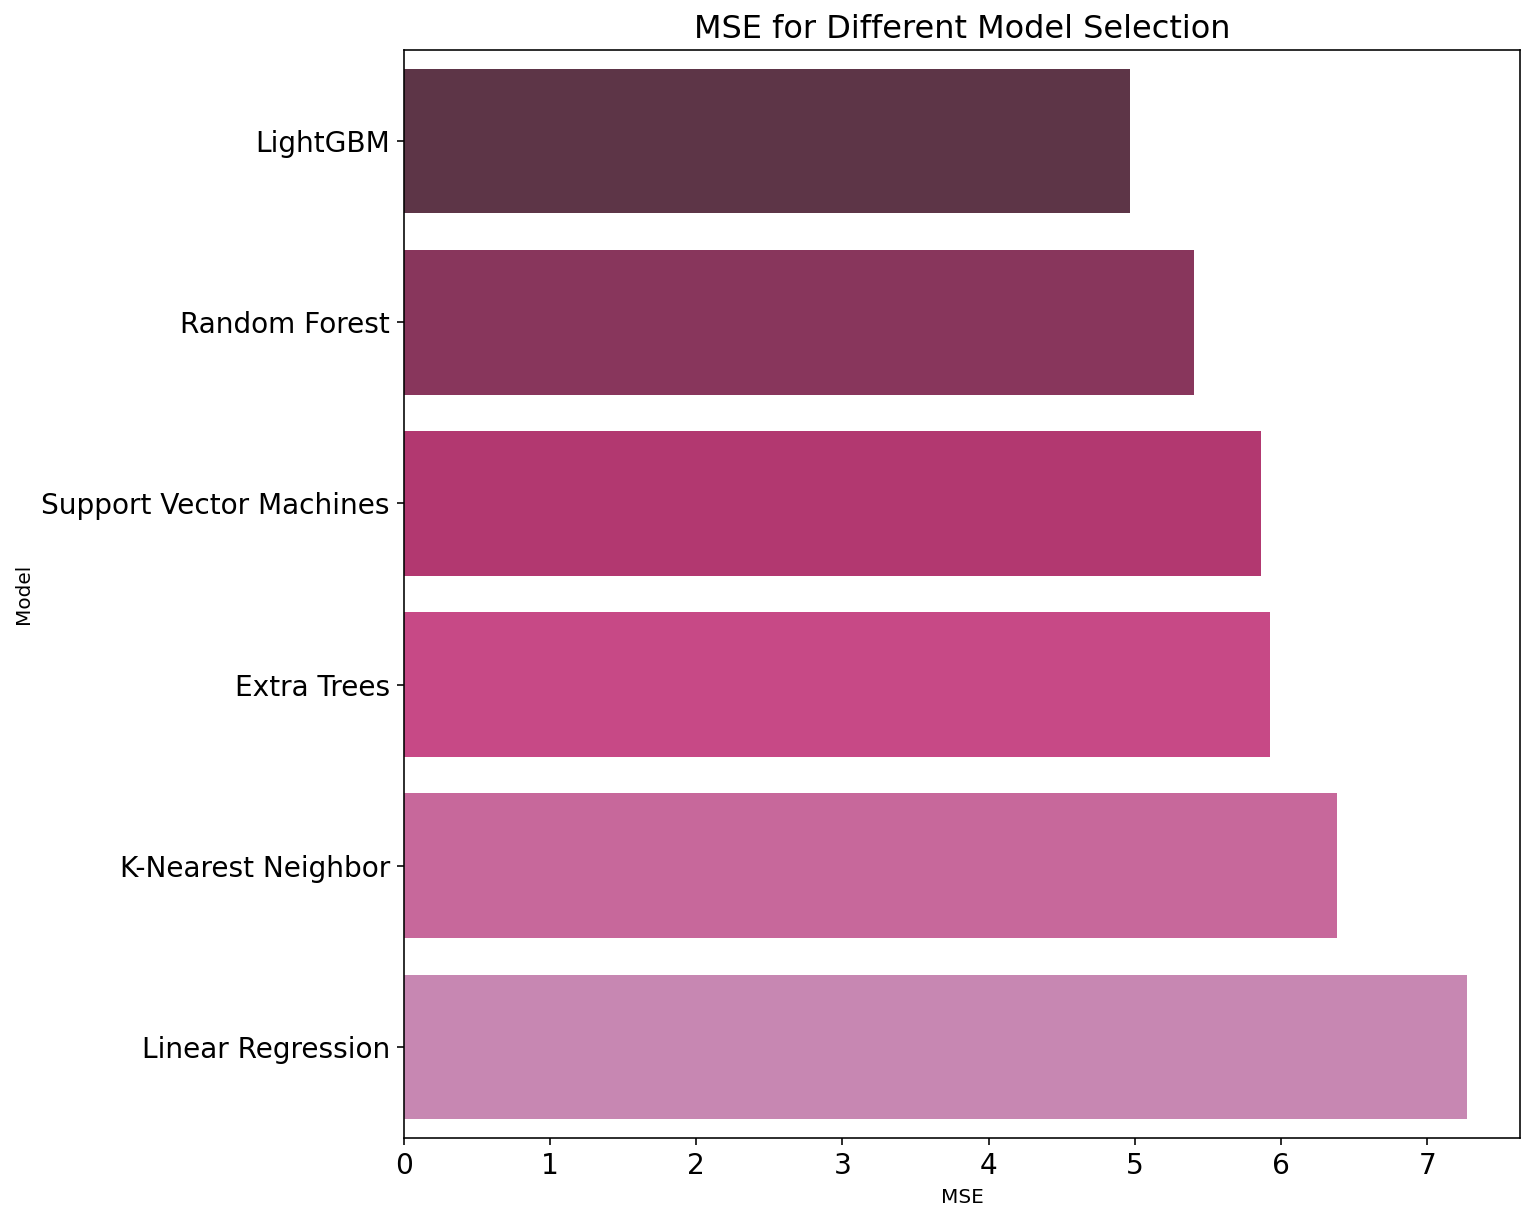

In [ ]:
# create dataframe of mse and model and sort values
performance_comparison = pd.DataFrame({'Model': 
                                       ['Linear Regression', 'K-Nearest Neighbor', 
                                        'Support Vector Machines', 'Random Forest', 
                                        'Extra Trees', 'LightGBM'],
                                       'MSE': 
                                       [mse_lr, mse_knn, mse_svm, 
                                        mse_rf, mse_xrf, mse_lgbm]})

performance_comparison = performance_comparison.sort_values(by='MSE', ascending=True)



# the plot
plt.figure(figsize=(10,10))
ax = sns.barplot(x='MSE', y='Model', data=performance_comparison, palette='PuRd_d')

# title arrange labels
plt.yticks(size=14)
plt.xticks(size=14)
plt.title('MSE for Different Model Selection', size=16)

Random forest and Light GBM algos showed they are potentially good predictors for our **wineRatingPredictor**

Both algos decreased baseline MSE by more than 40%

Next, we attempt to make additional improvements to RF and LGBM using Random Search with Cross Validation, and Hyperparameter Tuning

# 6. Perform Hyperparameter Tuning on Selected Model
We are going to search for the best set of parameters with **random search and k-fold cross validation**

**Random search** is the process of randomly combining the defined parameters and comparing the defined score, *MSE, for this problem*, with iterations. So, the most optimal dataset might be different than the *random search* results. However, this search algo is fast and run-time efficient

**K-fold cv** is the method used to assess the performance of hyperparameters on the entire dataset. Rather than splitting the dataset into 2 static subsets of training and validation sets, the dataset is divided equally for the given K. The model is trained with K-1 subsets and tested on Kth subset iteratively. This process makes each process more robust

In [ ]:
# add back df to perform Random Search + CV
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

X_array = convert_features_to_array(X)
y_array = convert_target_to_array(y)

### **Light GBM**
Parameters to optimized

+ **boosting type**: tree optimization method, default is gdbt
+ **n_estimators**: number of trees to be used in the model, default is 100
+ **learning_rate**: how fast algorithm optimizes the built trees, default is 0.1
+ **colsample_bytree**: sub-sample ratio of columns when constructing each tree, default is 1

In [ ]:
# define search parameters
boosting_type = ['gbdt', 'dart', 'goss', 'rf']
n_estimators = [100, 200, 300, 500, 1000]
learning_rate = [0.01, 0.02, 0.05, 0.1]
colsample_bytree = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

# define the grid for hyperparameters to search
hyperparameter_grid = {'boosting_type': boosting_type,
                       'n_estimators': n_estimators,
                       'learning_rate': learning_rate,
                       'colsample_bytree': colsample_bytree}

In [ ]:
# create randomized search object
lgbm_random_cv = RandomizedSearchCV(estimator=lgbm,
                                    param_distributions=hyperparameter_grid,
                                    cv=4, 
                                    n_iter=25,
                                    scoring='neg_mean_squared_error',
                                    n_jobs=-1, 
                                    verbose=1,
                                    return_train_score=True,
                                    random_state=42)

lgbm_random_cv.fit(X, y)

In [ ]:
lgbm_random_cv.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
              importance_type='split', learning_rate=0.02, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

After hyperparameter tuning, best set of hyperpramaters are determined as:

+ **boosting_type**: gbdt
+ **n_estimators**: 1000
+ **colsample_bytree**: 0.5
+ **learning_rate**: 0.02

### **Revisit MSE**

In [ ]:
lgbm_random_cv_model = lgbm_random_cv.best_estimator_

In [ ]:
# we begin our exploration with small samples
# before scaling it to production volume
# hence, its logical to gauge the time on how long the algo runs
%%time
lgbm = lgb.LGBMRegressor(random_state=42)
mse_lgbm_rcv = fit_evaluate_model(lgbm_random_cv_model,
                                  X_train_array,
                                  y_train_array,
                                  X_valid_array,
                                  y_valid_array)

print('MSE of light gradient boosting algorithm', mse_lgbm_rcv)

MSE of light gradient boosting algorithm 4.853705411207822
CPU times: user 2.35 s, sys: 157 ms, total: 2.51 s
Wall time: 1.28 s


MSE for lgbm decreased from 4.97 to 4.85, which is a 3% improvement compared to light gbm built with default parameters, at a higher run-time

### **Random Forest**
Parameters to be optimized

+ **n_estimators**: number of trees to be used in the model, default is 100
+ **min_samples_split**: minimum number of samples required to split an internal node, default value is 2
+ **min_samples_leaf**: minimum number of samples required to be at a leaf node, default value is 1
+ **max_features**: number of features to consider when looking for the best split, default value is auto

In [ ]:
# define search parameters
n_estimators = [100, 200, 300, 500, 1000]
min_samples_split = [2, 4, 6, 10]
min_samples_leaf = [1, 2, 4, 6, 8]
max_features = ['auto', 'sqrt', 'log2', None]

# define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features}

In [ ]:
# create randomized search object
rf_random_cv = RandomizedSearchCV(estimator=rf,
                                  param_distributions=hyperparameter_grid,
                                  cv=4, 
                                  n_iter=25,
                                  scoring='neg_mean_squared_error',
                                  n_jobs=-1, 
                                  verbose=1,
                                  return_train_score=True,
                                  random_state=42)

rf_random_cv.fit(X, y)

In [ ]:
rf_random_cv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

After hyperparameter tuning, best set of hyperpramaters are determined as

+ **n_estimators**: 200
+ **min_samples_split**: 4
+ **min_samples_leaf**: 2
+ **max_features**: sqrt

### **Revisit MSE**

In [ ]:
rf_random_cv_model = rf_random_cv.best_estimator_

In [ ]:
%%time
mse_rf_rcv = fit_evaluate_model(rf_random_cv_model,
                                X_train_array,
                                y_train_array,
                                X_valid_array,
                                y_valid_array)

print('MSE of random forests algorithm', mse_rf_rcv)

MSE of random forests algorithm 4.990440242105872
CPU times: user 1.46 s, sys: 5.67 ms, total: 1.46 s
Wall time: 1.47 s


# Conclusion
We started out with the baseline MSE of 9.01. linear regression, knn, svm, and extra trees regressor could only beat the baseline metric with a slight difference. Thus, eliminating them from the potential good predictor model list

*RF and light GBM* have beaten the baseline MSE by more than 40% which is a significant improvement. Thus they are selected as potential good predictors

Hyperparameter tuning was performed on the potential good predictors, where we searched for more suitable parameters for a given feature set. Light GBM's MSE improved from 4.97 to 4.85, and the tuned model run-time resulted in 1.17 seconds 

On the other hand, RF MSE improved more after the hyperparamater tuning. Its MSE decreased from 5.41 to 4.99 and the tuned model run-time resulted in 1.13 seconds which is lower than the initial RF model

Although tuned light GBM's MSE is lower than the tuned RF model, I'll select the RF algo as my predictor. My goal was to illustrate a good prediction for wine points are possible by using **machine learning**, and my tuned RF model has already satisfied that requirement

Other important considerations for our model selection are:
+ the improvement on the MSE between the initial and tuned model,
+ algorithm explainability and 
+ model run-times

Let's save our fine-tuned RF model as output for this file, and continue by training our model on the entire training set in the last notebook

In [ ]:
# filename = 'random_forests_model.sav'
# pickle.dump(rf_random_cv_model, open(filename, 'wb'))

![](https://drive.google.com/uc?export=view&id=1i7fzIUxz-oEs8V4uMdoZCQUl51NMrbVz)